Run the following cell to force the stdout results appear on your terminal.
This prevents your notebook of gettin cluterred with the logs of the software executed in background.

In [1]:
import sys
import os
import platform

if platform.uname().system != "Linux":
    sys.stdout = open('/dev/stdout', 'w')

## Importing essential Python Packages

In [2]:
import sys, os

pysbf_path = "/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/codes/"
sys.path.insert(0, pysbf_path)
from pysbf import *

from IPython.display import display, Markdown, clear_output
warnings.filterwarnings('ignore')

## Installing Required Python Packages

- **Note:** If this is your first time running this notebook, check the following box to install all required python packages.

In [3]:
install_box = widgets.Checkbox(description='Install Packges', value = False)
install_box

Checkbox(value=False, description='Install Packges')

In [4]:
if install_box.value:
    xcmd("pip install -r {}/pysbf/requirements.txt".format(pysbf_path))

## Object Initialization

In [5]:
## This is the folder that holds recent observations by wfc3 on HST in a SNAP program

inFolder = '/home/ehsan/PanStarrs/Jan/HI/augment/SBF/codes/notebooks/data/wfc3/'
outFolder = '/home/ehsan/PanStarrs/Jan/HI/augment/SBF/codes/notebooks/output/'
configFolder = pysbf_path + 'pysbf/config/'

box_new = widgets.Checkbox(description='Force New Session', value = False)
box_new

Checkbox(value=False, description='Force New Session')

### Force New

- Set to `True` (check the above box) to generate a new working session. All parameters would be reset to default values, and all output files would be stored in a new folder with the same name.

- Default is `False`, if the session doesn't exist, it creates a new one, otherwise it starts from lastest parameters stored in the logfile and continues saving outputs in the same folder as the existing sessin.

In [6]:
name = "c540079"

In [7]:
obj = SBFobject(name, 
                inFolder=inFolder, 
                outFolder=outFolder,
                config=configFolder, 
                force_new=box_new.value)

In [8]:
s = obj.slider_back_threshold()

widgets.HBox(s)

Back Median: 3868.74
Back Mean: 3869.69
Back Stdev: 87.62
fig. name:  /home/ehsan/PanStarrs/Jan/HI/augment/SBF/codes/notebooks/output/Outputs_c540079/c540079_daad829acb35/c540079_initial_back.png


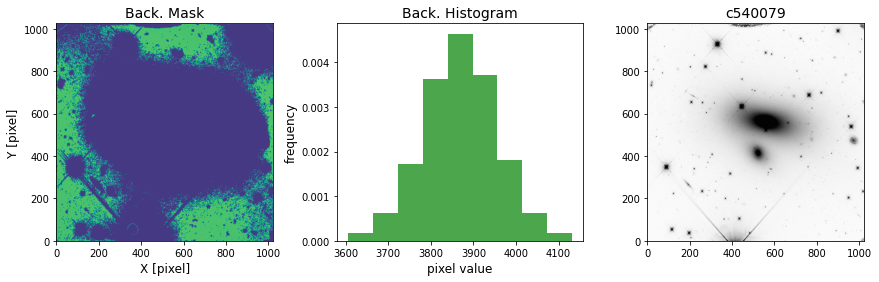

In [9]:
%matplotlib inline

_ = obj.plot_back_mask()

Here, we do a crude calculations to generate an initial mask. The main objective is to mask out the large objects in the field.

- `minArea`: the minimum number of pixels in the masked regions
- `thresh`: the threshold factor that represents the signal to noise ratio of the detected segmented areas. Larger values would reduce the number of masked, because larger signal levels would satisfy the threshold condition.
- `smooth`: the smoothing factor. Larger values would enlarge the masked regions, because the signal is smeared across more neighborhood pixels.
- `mask=1`: the mask number. By default we start from `1`. However any other arbitrary integer value could be used.


*The segmentation and the associated generated mask are plotted.*
One may play with the input values to generate satisfactory initial masks.

## Profile

In [10]:
obj.objRoot

'/home/ehsan/PanStarrs/Jan/HI/augment/SBF/codes/notebooks/output/Outputs_c540079/c540079_daad829acb35/'

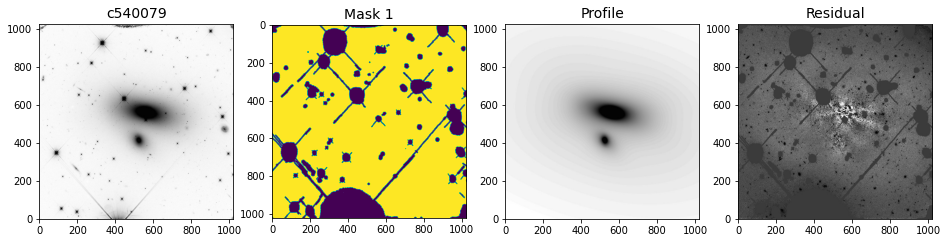

In [11]:
%matplotlib inline

profile_name = obj.inFolder + "{}/{}".format(obj.name, "c540j.prf")
_ = obj.insert_existing_profile(profile=profile_name)

Checkbox(value=False, description='Combine Mask')

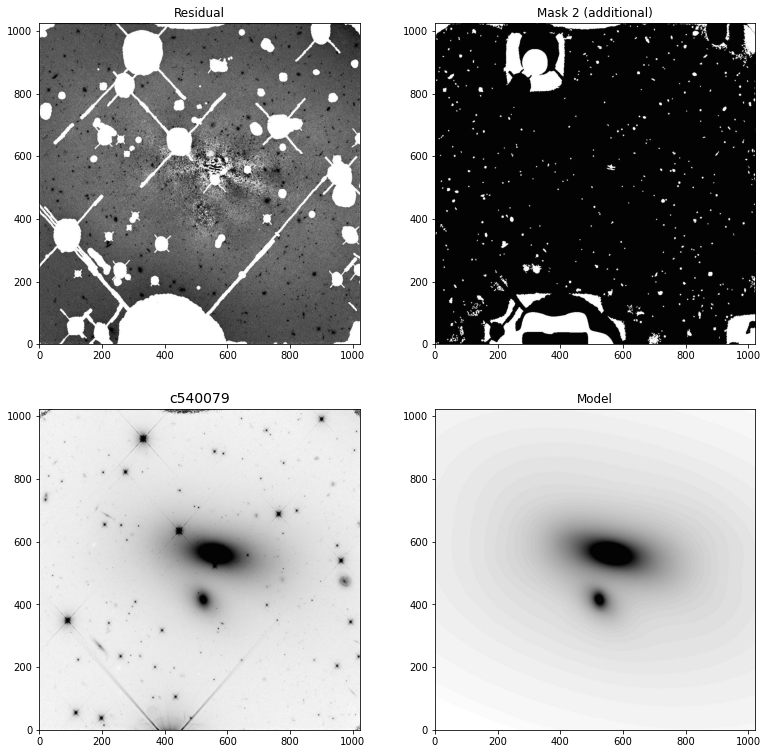

In [15]:
# using residuals of model 0 --> mask 2
obj.objSourceExtract(
    model=0,mask=2)
#     smooth=smooth,
#     minArea=minarea,
#     thresh=threshold,
#     mask=2,
#     renuc=renuc,)

fig, ax = plt.subplots(2, 2, figsize=(13, 13))

obj.tv_resid(model=0, ax=ax[0][0], options="sqrt")
ax[0, 0].set_title("Residual")

obj.tv_mask(mask=2, ax=ax[0][1])
ax[0, 1].set_title("Mask 2 (additional)")

obj.tv(ax=ax[1][0], options="sqrt")
ax[1][0].set_title(obj.name, fontsize=14)

obj.tv_model(model=0, ax=ax[1, 1], options="sqrt")
ax[1, 1].set_title("Model")


checkbox = widgets.Checkbox(description='Combine Mask', value = False)
checkbox

## Mask augmentation

If we are happy with the additional mask we found above, we add these two masks and update the primary mask.
After updating the mask (`mask=1`), the previous cell can be iteratively executed with updating the mask multiple time until we are satisfied.

In [16]:
# combining mask1 and mask2 ----> mask1
if checkbox.value==True:
    obj.addMasks(maskList=[1,2], mask=1)

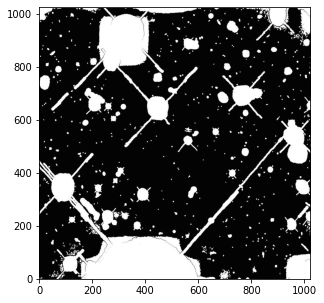

In [17]:
%matplotlib inline

plt.figure(figsize=(5,5))
plt.subplot(111)
ax = plt.gca()
obj.tv_mask(mask=1, ax=ax)

pngName = obj.objRoot+'/'+obj.name+'_combined_mask.png'
plt.savefig(pngName)

## Updating the background level

Here, we update the background factor, and regenerate the `elliprof` model until the median of the residual value of the background pixels is roughly zero. 

In [20]:
## Updating background level?

option = obj.params["second_elliprof"]["option"]
c_kron = obj.params["second_elliprof"]["c_kron"]
k = obj.params["second_elliprof"]["k_ellipse"]

r0         = obj.params["second_elliprof"]["r0"] 
r1         = obj.outerR(c_kron)      
nr         = int(np.round((r1-r0)/k))
initial_sky_factor = obj.params["second_elliprof"]["sky_factor"]

# model #: the elliprof model id
optimized_sky_factor = obj.optimize_sky_factor(initial_sky_factor, r0, r1, nr, options=option, model=999)   

print("Optimized sky factor: ", "%.3f"%optimized_sky_factor)


Optimized sky factor:  0.907


# Decide what `sky_factor` to use !
 
### This is still manual !!!
and requires the user to decide what vlaue by using the optimization procedure or other methods

- Use either cells, to enter your desired sky_factor, or the sky level. 
- In the end, the sky background level is converted into a sky_factor parameter 

In [23]:
sky_factor = 0.9
s_factor = widgets.FloatSlider(value=sky_factor, min=0, max=1.2,step=0.01, description="Sky_factor")
s_value = widgets.Text(value=str(int(obj.sky_med * sky_factor)), description="Sky Value")

def factor_func(change):
    s_value.value = str(int(float(s_factor.value)*obj.sky_med))


def value_func(change):
    s_factor.value = str(float(s_value.value) / obj.sky_med)
    
s_factor.observe(factor_func , names='value')
s_value.observe(value_func , names='value')

widgets.VBox([s_factor, s_value])

In [24]:
sky_factor = float(s_factor.value)
sky = int(s_value.value)

    
print("[SKY factor]: %.3f"%sky_factor)
print("[SKY]: %.d"%sky)

[SKY factor]: 0.900
[SKY]: 3481


## Plotting the light profile

So far, we found the optimum **sky factor** and the `initial mask`.
`r0` and `r1` has been chosen by user iteratively to get reasonable results.

Now, we visualize the light profile of galaxy and the residual image for the final check.

In the following plot we have
- **Left:** The light profile. Each point show the surface brightness on an ellipse. The horizontal axis is scaled to accommodate the `r^1/4` form. Open black circles represent the region used to find the red dotted line in a least square process. This linear fit is extrapolated towards larger radii to examine the behavior of the outer region. If a galaxy follows a pure `r^1/4`, all outer point must fall on the fitted line.

- **Right:** The residual image, which is generated by subtracting the primary model from the galaxy image. Red concentric ellipse are the ellipses. Yellow circles represent the region used for the linear fit in the left panel.

- Choosing the radius range to fit a line on the surface brightness

In [25]:
my_widget = widgets.IntRangeSlider(
                    value=[70, 90],
                    min=0,
                    max=100,
                    step=1,
                    description="Range (%)",
                )
my_widget

IntRangeSlider(value=(70, 90), description='Range (%)')

In [26]:
main_key = "second_elliprof"

# extracting parameter
# feel free to use other parameters too
r0 = obj.params[main_key]["r0"]
c_kron = obj.params[main_key]["c_kron"]
r1 = obj.outerR(c_kron)
k = obj.params[main_key]["k_ellipse"]
nr = int(np.round((r1 - r0) / k))
options = obj.params[main_key]["option"]

# plotting
axes = obj.plot_profile(sky_factor, r0, r1, nr, options=options, fit_imits=my_widget.value)

KeyError: 'second_elliprof'

## Visualizing the background histogram

In the following cell, the distribution of the residual values of the background pixels is plotted.
In the case of having a good model and sky value, the median/mean values of the residuals should be close to zero.

**Note:** Sometimes, very bright objects must be masked out manually to makes sure that there no contamination from such objects, otherwise the background must have been over-estimated.

Back Median: 23.21
Back Mean: 26.46
Back Stdev: 97.77
fig. name:  /home/ehsan/PanStarrs/Jan/HI/augment/SBF/codes/notebooks/output/Outputs_u12517/u12517_eb317d7f178c/u12517_updated_back.png

New potential sky factor: 0.906
Note that the suggested sky factor is determined based on the histogram of 
the background pixels in the residual image !!!


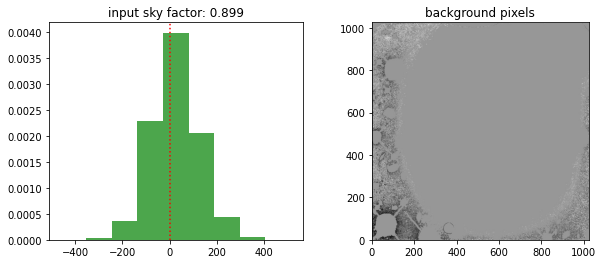

In [37]:
_ = obj.plot_back_histogram(sky_factor)

## Saving the model

Here, we store all metadata and other information on disk to be used in other steps.

In [38]:
df = obj.save_log(sky_factor)

df

Log File:  /home/ehsan/PanStarrs/Jan/HI/augment/SBF/codes/notebooks/output/Outputs_u12517/u12517_eb317d7f178c/../u12517_model_log.csv


,index,value,description
0,index,value,description
1,uuid,eb317d7f178c,Unique Identifier Code
2,User,Ehsan,User Name
3,Time,2023-04-24 00:23:00.805121,Modification Time
4,Name,u12517,Object Name
5,X_pixels,1022,X-dimension of image [pixel]
6,Y_pixels,1025,Y-dimension of image [pixel]
7,R_max,454,maximum horizontal/vertical distance from cent...
8,X0,567.631,Object Center X0 [pixel]
9,Y0,562.615,Object Center Y0 [pixel]
